# CNN Tuning for FashionMNIST Image Classification

## SMBO with spotPython

In [1]:
from spotPython.utils.init import fun_control_init
from spotPython.utils.file import get_experiment_name, get_spot_tensorboard_path
from spotPython.utils.device import getDevice
from torch import nn
import torch.nn.functional as F
import spotPython.torch.netcore as netcore
from torch.nn import CrossEntropyLoss
import torchmetrics
from spotPython.hyperparameters.values import get_var_type, get_var_name, get_bound_values
from spotPython.utils.eda import gen_design_table
from spotPython.fun.hypertorch import HyperTorch
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
from spotPython.spot import spot
from spotPython.hyperparameters.values import get_one_core_model_from_X
from math import inf
import numpy as np
from spotPython.torch.traintest import train_tuned, test_tuned
from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control

import torch
import torchvision
from torchvision.transforms import transforms

import warnings
warnings.filterwarnings("ignore")

from time import sleep, perf_counter

In [2]:
def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])

    trainset = torchvision.datasets.FashionMNIST(data_dir,
        download=True,
        train=True,
        transform=transform)
    testset = torchvision.datasets.FashionMNIST(data_dir,
        download=True,
        train=False,
        transform=transform)

    return trainset, testset

trainset, testset = load_data()

In [3]:
MAX_TIME = 360
INIT_SIZE = 10
DEVICE = "auto" # "cpu"
PREFIX = "fashionMNIST"

DEVICE = getDevice(DEVICE)
print(f'Device: {DEVICE}')

experiment_name = get_experiment_name(prefix=PREFIX)

fun_control = fun_control_init(
    task="classification",
    spot_tensorboard_path=get_spot_tensorboard_path(experiment_name),
    device=DEVICE)

Global seed set to 42


Device: cuda:0


In [4]:
# add the dataset to the fun_control
fun_control.update({
    "train": trainset,
    "test": testset,
    "n_samples": len(trainset)})

In [5]:
# no tuning of data preparation step
prep_model = None
fun_control.update({"prep_model": prep_model})

In [6]:
class Net_FashionMNIST(netcore.Net_Core):
    def __init__(self, l1, lr_mult, batch_size, epochs, k_folds, patience,
    optimizer, sgd_momentum):
        super(Net_FashionMNIST, self).__init__(
            lr_mult=lr_mult,
            batch_size=batch_size,
            epochs=epochs,
            k_folds=k_folds,
            patience=patience,
            optimizer=optimizer,
            sgd_momentum=sgd_momentum,
        )

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, l1)
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
core_model = Net_FashionMNIST
add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename="fashionMNIST_hyper_dict.json")

fun_control.update({"loss_function": CrossEntropyLoss()})

metric_torch = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(fun_control["device"])
fun_control.update({"metric_torch": metric_torch})

fun_control.update({
    "eval": "train_hold_out",
    "path": "torch_model.pt",
    "shuffle": True})

print(gen_design_table(fun_control))

| name         | type   | default   |   lower |   upper | transform             |
|--------------|--------|-----------|---------|---------|-----------------------|
| l1           | int    | 7         |     5   |     8   | transform_power_2_int |
| lr_mult      | float  | 1.0       |     0.1 |    10   | None                  |
| batch_size   | int    | 6         |     4   |     7   | transform_power_2_int |
| epochs       | factor | 15        |     0   |     3   | None                  |
| k_folds      | int    | 0         |     0   |     0   | None                  |
| patience     | int    | 3         |     3   |     3   | None                  |
| optimizer    | factor | SGD       |     0   |     0   | None                  |
| sgd_momentum | float  | 0.9       |     0.9 |     0.9 | None                  |


In [8]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

fun = HyperTorch().fun_torch
X_start = get_default_hyperparameters_as_array(fun_control)

spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   max_time = MAX_TIME,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000
                                      })

t0 = perf_counter()
spot_tuner.run(X_start=X_start)
print(perf_counter()-t0)


config: {'l1': 64, 'lr_mult': 2.0267171913857998, 'batch_size': 32, 'epochs': 15, 'k_folds': 0, 'patience': 3, 'optimizer': 'SGD', 'sgd_momentum': 0.9}
Epoch: 1 | MulticlassAccuracy: 0.6309999823570251 | Loss: 1.3855386177698772 | Acc: 0.6310000000000000.
Epoch: 2 | MulticlassAccuracy: 0.7139583230018616 | Loss: 0.9076357819239298 | Acc: 0.7139583333333334.
Epoch: 3 | MulticlassAccuracy: 0.7369583249092102 | Loss: 0.7752971459229787 | Acc: 0.7369583333333334.
Epoch: 4 | MulticlassAccuracy: 0.7485833168029785 | Loss: 0.7202352805932363 | Acc: 0.7485833333333334.
Epoch: 5 | MulticlassAccuracy: 0.7577499747276306 | Loss: 0.6862714418172836 | Acc: 0.7577500000000000.
Epoch: 6 | MulticlassAccuracy: 0.7632916569709778 | Loss: 0.6656829074621201 | Acc: 0.7632916666666667.
Epoch: 7 | MulticlassAccuracy: 0.7688750028610229 | Loss: 0.6488109918832778 | Acc: 0.7688750000000000.
Epoch: 8 | MulticlassAccuracy: 0.7757916450500488 | Loss: 0.6361446639299393 | Acc: 0.7757916666666667.
Epoch: 9 | Mult

In [16]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name         | type   | default   |   lower |   upper |             tuned | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|-------------------|-----------------------|--------------|---------|
| l1           | int    | 7         |     5.0 |     8.0 |               7.0 | transform_power_2_int |         1.04 | *       |
| lr_mult      | float  | 1.0       |     0.1 |    10.0 | 5.572429522468743 | None                  |        32.87 | *       |
| batch_size   | int    | 6         |     4.0 |     7.0 |               4.0 | transform_power_2_int |        11.84 | *       |
| epochs       | factor | 15        |     0.0 |     3.0 |               3.0 | None                  |       100.00 | ***     |
| k_folds      | int    | 0         |     0.0 |     0.0 |               0.0 | None                  |         0.00 |         |
| patience     | int    | 3         |     3.0 |     3.0 |               3.0 | None                  |         0

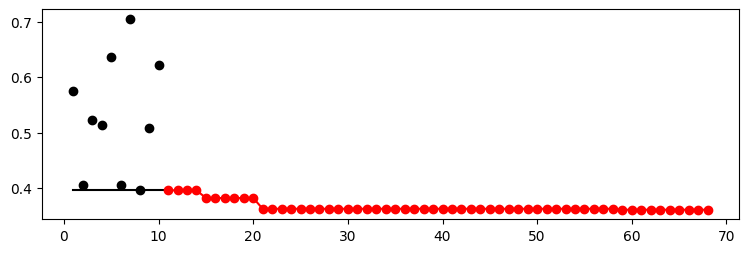

In [17]:
spot_tuner.plot_progress()

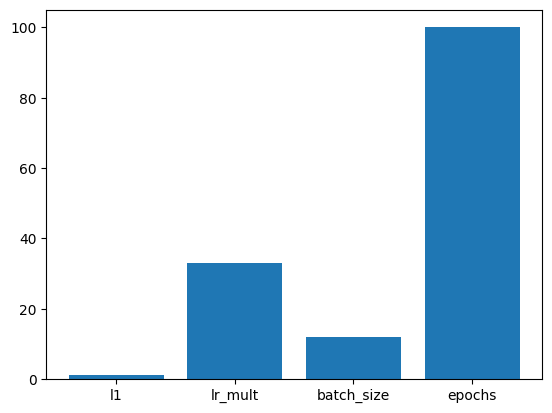

In [18]:
spot_tuner.plot_importance(threshold=0.025)

In [19]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_FashionMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [22]:
train_tuned(net=model_spot, train_dataset=trainset,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = fun_control["device"],
        path=None,
        task=fun_control["task"],)
test_tuned(net=model_spot, test_dataset=testset,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = fun_control["device"],
            task=fun_control["task"],)

Epoch: 1 | MulticlassAccuracy: 0.7515833377838135 | Loss: 0.6975112879375617 | Acc: 0.7515833333333334.
Epoch: 2 | MulticlassAccuracy: 0.7776250243186951 | Loss: 0.6188557817439239 | Acc: 0.7776250000000000.
Epoch: 3 | MulticlassAccuracy: 0.7860833406448364 | Loss: 0.5816513923257589 | Acc: 0.7860833333333334.
Epoch: 4 | MulticlassAccuracy: 0.7967083454132080 | Loss: 0.5525762554655472 | Acc: 0.7967083333333334.
Epoch: 5 | MulticlassAccuracy: 0.8116666674613953 | Loss: 0.5233077650964260 | Acc: 0.8116666666666666.
Epoch: 6 | MulticlassAccuracy: 0.8036249876022339 | Loss: 0.5212544192671775 | Acc: 0.8036250000000000.
Epoch: 7 | MulticlassAccuracy: 0.8233749866485596 | Loss: 0.4855683011809985 | Acc: 0.8233750000000000.
Epoch: 8 | MulticlassAccuracy: 0.8281250000000000 | Loss: 0.4701318847586711 | Acc: 0.8281250000000000.
Epoch: 9 | MulticlassAccuracy: 0.8259583115577698 | Loss: 0.4680934885541598 | Acc: 0.8259583333333333.
Epoch: 10 | MulticlassAccuracy: 0.8424999713897705 | Loss: 0.441

(0.42195078079104426, nan, tensor(0.8479, device='cuda:0'))

l1:  1.0411986841998757
lr_mult:  32.87074540893972
batch_size:  11.842229641747762
epochs:  100.0


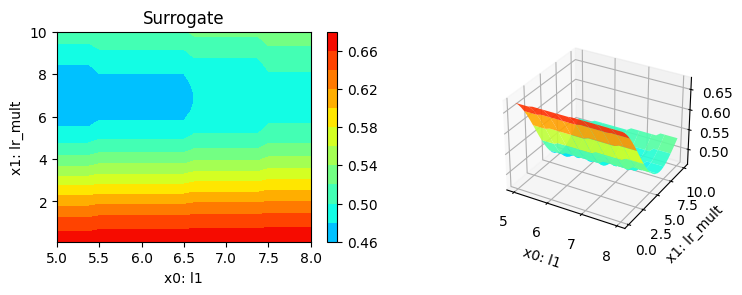

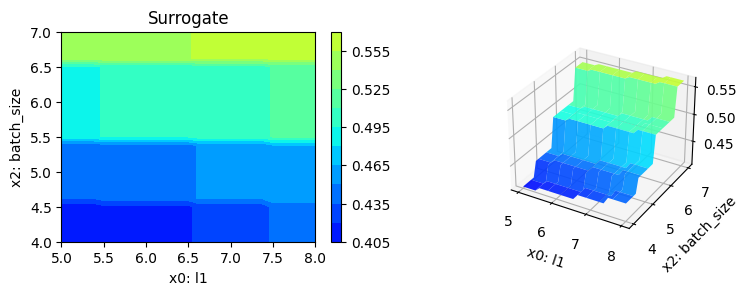

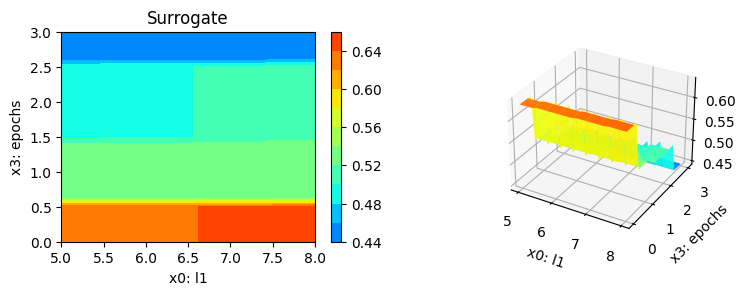

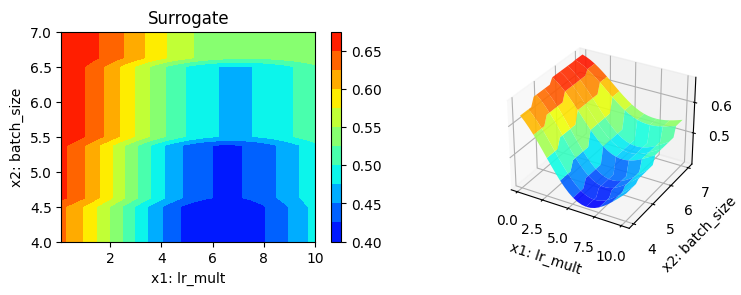

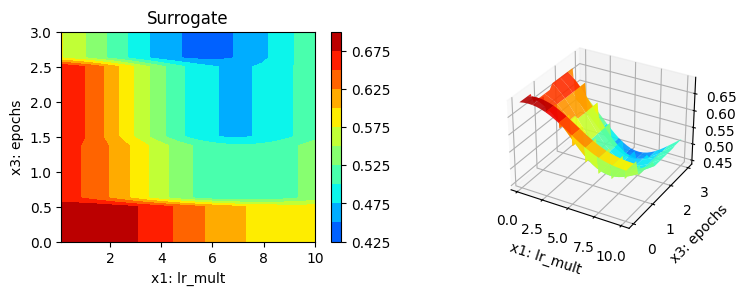

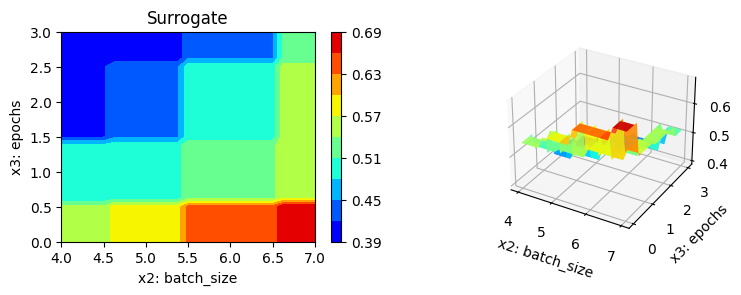

In [20]:
spot_tuner.plot_important_hyperparameter_contour()

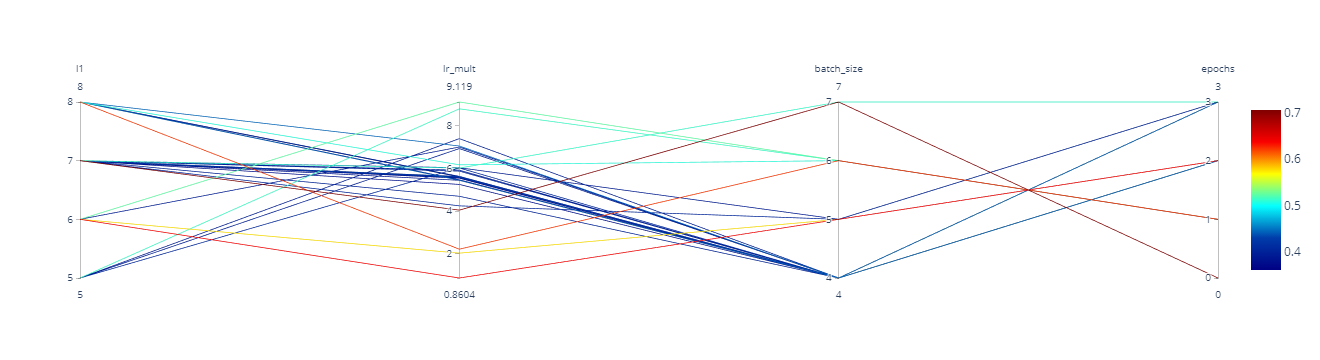

In [21]:
spot_tuner.parallel_plot()

In [23]:
import pickle
SAVE = True
LOAD = False

if SAVE:
    result_file_name = "spot_runs_23-08-2023.pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "spot_runs_23-08-2023.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)